### Network MultiAgent with realtime tools

In [21]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

In [1]:
import os
from langchain_community.tools.tavily_search import TavilySearchResults

TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
search_tool=TavilySearchResults(tavily_api_key=TAVILY_API_KEY)
search_tool.invoke("who is a current pm of uk?")

/var/folders/wp/9w_2m0xn5clfmrkfxjxl7cm00000gn/T/ipykernel_68288/2355595506.py:5: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_tool=TavilySearchResults(tavily_api_key=TAVILY_API_KEY)


[{'title': 'Prime Minister - GOV.UK',
  'url': 'https://www.gov.uk/government/ministers/prime-minister',
  'content': 'The Prime Minister is the leader of His Majesty’s Government and is ultimately responsible for the policy and decisions of the government.\n\nAs leader of the UK government the Prime Minister also:\n\n## Current role holder\n\n### The Rt Hon Sir Keir Starmer KCB KC MP\n\nSir Keir Starmer became Prime Minister on 5 July 2024.\n\n## Education [...] Keir attended Reigate Grammar School, before studying Law at the University of Leeds. He went on to do postgraduate studies at the University of Oxford, receiving a Bachelor of Civil Law (BCL) degree.\n\n## Political Career\n\nKeir was elected a Member of Parliament for Holborn and St Pancras in May 2015. He was elected leader of the Labour Party in April 2020.\n\n## Career before politics [...] Find out more about previous holders of this role in our past Prime Ministers section.\n\n## Announcements\n\n## Subscriptions\n\n## 

In [2]:
from langchain_experimental.utilities import PythonREPL

repl=PythonREPL()
code = """
x = 5
y = x * 2
print(y)
"""
repl.run(code)

Python REPL can execute arbitrary code. Use with caution.


'10\n'

In [7]:
from langchain_core.tools import tool
from typing import Annotated

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    print("Executing Python code:", code)
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [8]:
python_repl_tool.run(code)

Executing Python code: 
x = 5
y = x * 2
print(y)



'Successfully executed:\n\\`\\`\\`python\n\nx = 5\ny = x * 2\nprint(y)\n\n\\`\\`\\`\nStdout: 10\n\n\nIf you have completed all tasks, respond with FINAL ANSWER.'

In [9]:
def make_system_prompt(instruction:str)->str:
    return  (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{instruction}"
    )

make_system_prompt("You can only do research. You are working with a chart generator colleague.")

"You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools  will help where you left off. Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER so the team knows to stop.\nYou can only do research. You are working with a chart generator colleague."

In [11]:
from langchain_core.messages import BaseMessage, HumanMessage

def get_next_node(last_message:BaseMessage, goto:str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

In [16]:
#agent1
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent
from typing_extensions import Literal

def research_node(state:MessagesState)->Command[Literal["chart_generator", END]]:
    research_agent=create_react_agent(
        llm,
        tools=[search_tool],
        checkpointer=True,
        prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
    )
    result=research_agent.invoke(state)
    goto=get_next_node(result["messages"][-1],"chart_generator")
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="researcher")
    return Command(update={"messages": result["messages"]},goto=goto)

In [17]:
#agent2
def chart_node(state:MessagesState)-> Command[Literal["researcher", END]]:
    chart_agent=create_react_agent(
        llm,
        tools=[python_repl_tool],
        prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
        )
    result=chart_agent.invoke(state)
    goto=get_next_node(result["messages"][-1],"researcher")
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="chart_generator")
    return Command(update={"messages": result["messages"]},goto=goto)

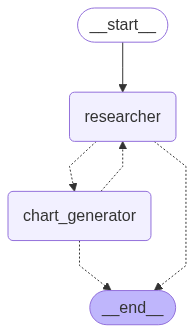

In [22]:
workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
app = workflow.compile()
app

In [ ]:
!pip3 install matplotlib

Executing Python code: import matplotlib.pyplot as plt

# GDP data
years = [2021, 2022, 2023]
gdp_values = [3.143, 3.114, 3.381] # in trillion USD

# Creating the line chart
plt.figure(figsize=(10, 6))
plt.plot(years, gdp_values, marker='o', linestyle='-', color='b')

# Adding titles and labels
plt.title('UK GDP Over the Past 3 Years')
plt.xlabel('Year')
plt.ylabel('GDP (in Trillions USD)')
plt.grid(True)
plt.xticks(years)

# Display the plot
plt.show()


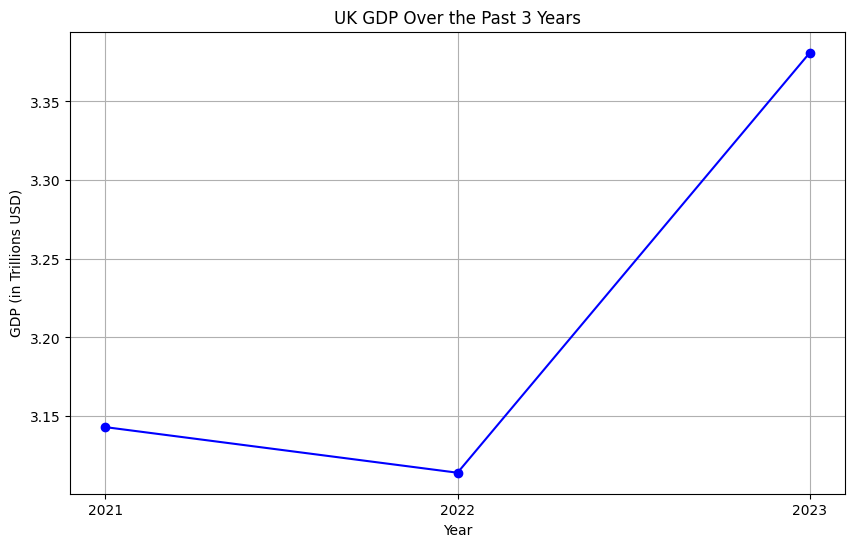

{'messages': [HumanMessage(content="get the UK's GDP over the past 3 years, then make a line chart of it.Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='c091437e-8100-4887-b602-b6abdf4123be'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_uLr1ChtuAFO97VQH4FRNbkAx', 'function': {'arguments': '{"query":"UK GDP data over past 3 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 205, 'total_tokens': 230, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-Bs4Y48gC1TF1hvo4CjEPWAwmg1SoK', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--f9e6ca6

In [23]:
app.invoke({"messages": [("user","get the UK's GDP over the past 3 years, then make a line chart of it.Once you make the chart, finish.")],})